In [1]:
import os
from os import path

LABELS_DIR = "labels"
DATA_DIR = "data"
AUG_DIR = "aug"

if path.exists(AUG_DIR):
    os.rmdir(AUG_DIR)

for root, dirs, files in os.walk(DATA_DIR):
    for dir in dirs:
        new_root = f"{AUG_DIR}/{root[5:]}/{dir}"
        if not path.exists(new_root):
           os.makedirs(new_root)

In [1]:
import os
from os import path

import torch
from torch.utils.data import Dataset
import torchvision.io as io
import pandas as pd


class OCRDataset(Dataset):
    def __init__(self, dataset_dir, labels_dir, transform, device=None):
        self.dataset_dir = dataset_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.device = device
        self.df = self.build_df()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df["file_name"][idx]
        # prepare image (i.e. resize + normalize)
        img = io.read_image(
            path.join(self.dataset_dir, file_name))
        if self.device:
            img.to(self.device)
        return (file_name, self.transform(img))

    def build_df(self):
        li = []
        for root, dirs, files in os.walk(self.labels_dir):
            for file in files:  # Loop through the dataset tsvfiles
                if not file.endswith(".tsv"):
                    continue

                print(f"Processing {file}")
                li.append(pd.read_table(path.join(root, file),
                          names=["file_name", "text"]))

        return pd.concat(li, axis=0, ignore_index=True)

In [2]:
import torch

import torchvision.transforms.v2 as transforms
from torchvision.transforms.v2 import InterpolationMode

LABELS_DIR = "labels"
DATA_DIR = "data"
AUG_DIR = "aug"

transform = transforms.Compose([
    transforms.Resize(
        (64, 1024), interpolation=InterpolationMode.BILINEAR, antialias=True),
])

dataset = OCRDataset(DATA_DIR, LABELS_DIR,
                     transform=transform, device=torch.device("cuda"))

/home/dotin13/mijo/GitHub/hand-syn/tang-syn/venv/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/dotin13/mijo/GitHub/hand-syn/tang-syn/venv/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to u

Processing digit_95k.tsv
Processing hand_line_all_548k.tsv
Processing tang_syn_1577k.tsv
Processing web_line_238k.tsv
Processing hw_chinese_240k.tsv
Processing hwdb_ic13_47k.tsv
Processing hwdb2.1_13k.tsv
Processing hwdb2.2_12k.tsv
Processing hwdb2.0_16k.tsv
Processing signatures_472k.tsv
Processing hwdb2.0_4k.tsv
Processing hwdb_ic13_3k.tsv
Processing hw_chinese_17k.tsv
Processing hwdb2.2_3k.tsv
Processing hwdb2.1_3k.tsv
Processing hwdb_ic13_val_5k.tsv


In [3]:
from os import path
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

from data_aug import build_data_aug

DATA_DIR = "data"
LABELS_DIR = "labels"
AUG_DIR = "aug"


device = torch.device("cuda")

batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size)

transform = build_data_aug((64, 1024), "train", device=device)

for batch in tqdm(data_loader):
    input_images = batch[1]
    transformed_batch = transform(input_images.to(device))
    for i, item in enumerate(transformed_batch):
        img = item
        save_image(img, path.join(AUG_DIR, batch[0][i]))


/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
  3%|▎         | 373/12879 [03:31<1:58:18,  1.76it/s]


RuntimeError: stack expects each tensor to be equal size, but got [3, 64, 1024] at entry 0 and [1, 64, 1024] at entry 192

In [ ]:
import os
from os import path

import torch
from tqdm import tqdm
import torchvision
import torchvision.io as io
from data_aug import build_data_aug


LABELS_DIR = "labels"
DATA_DIR = "data"
AUG_DIR = "aug"

device = torch.device("cuda")
tfm = build_data_aug(64, "train", device=device)

for root, dirs, files in os.walk(LABELS_DIR):
    for file in files:  # Loop through the dataset tsvfiles
        if not file.endswith(".tsv"):
            continue

        print(f"Processing {file}")

        with open(path.join(root, file), "r", encoding="utf-8") as tsvfile:

            for line in tqdm(tsvfile):  # Loop through lines in the tsvfile
                if not line:
                    continue

                image_file = line.split("\t")[0]
                image_path = path.join(DATA_DIR, image_file)
                if not path.exists(image_path):
                    raise Exception(f"Image file {image_file} not found")

                # aug_dir = path.join(AUG_DIR, "/".join(image_file.split("/")[:-1]))
                # if not path.exists(aug_dir):
                #     os.makedirs(aug_dir)

                # input_image = io.read_image(path.join(DATA_DIR, image_file))
                # augmented = tfm(input_image.to(device))

                # output_path = path.join(AUG_DIR, image_file)
                # torchvision.utils.save_image(augmented, output_path)

/home/dotin13/mijo/GitHub/hand-syn/tang-syn/venv/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/dotin13/mijo/GitHub/hand-syn/tang-syn/venv/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to u

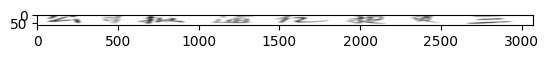

In [1]:
"""V2 Testing"""

from torchvision.transforms import functional

import torch
import torchvision.io as io
from numpy import asarray
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from data_aug import build_data_aug

device = torch.device("cuda")
input_image = io.read_image("0.png").unsqueeze(0).to(device)
tfm = build_data_aug((64, 3072), "train", device=device)
augmented = tfm(input_image)

plt.imshow(functional.to_pil_image(augmented.cpu()[0]))

# input_image = input_image.filter(ImageFilter.MinFilter(3))
# plt.imshow(input_image)
plt.show()

In [ ]:
"""V1 Testing"""

from torchvision.transforms import functional

import torch
import torchvision.io as io
from numpy import asarray
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from data_aug import build_data_aug

input_image = Image.open("0.png")
tfm = build_data_aug(64, "train")
augmented = tfm(input_image)

# plt.imshow(functional.to_pil_image(augmented.cpu()[0]))

# plt.imshow(augmented.cpu())

plt.imshow(functional.to_pil_image(augmented))

# input_image = input_image.filter(ImageFilter.MinFilter(3))
# plt.imshow(input_image)
plt.show()